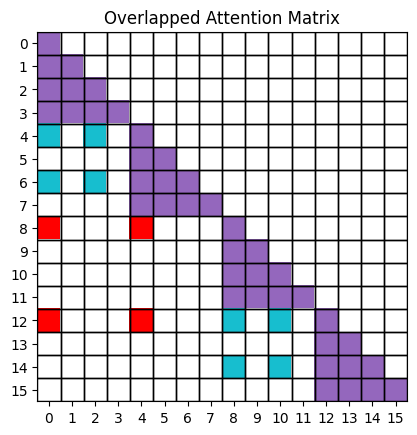

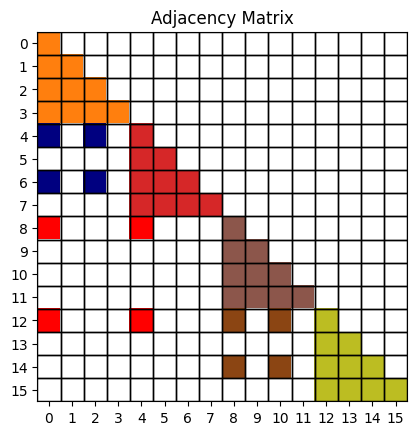

In [1]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


N = 16  # Sequence length
w0 = 4  # Initial window size
r0 = 1  # Initial stride size
alpha = 2  # Geometric progression factor

# Number of different (w,r) pairs. Can be calculated given that w and r are in geometric progression

k = int(np.log(N / w0) / np.log(alpha)) + 1

# Generate the w_seq as a geometric progression
w_seq = [w0 * alpha**i for i in range(k)]
# Generate the r_seq as a geometric progression
r_seq = [r0 * alpha**i for i in range(k)]

colors = [
    "#FFFFFF",
    "#1F77B4",
    "#FF7F0E",
    "#2CA02C",
    "#D62728",
    "#9467BD",
    "#8C564B",
    "#E377C2",
    "#7F7F7F",
    "#BCBD22",
    "#17BECF",
    '#000080',
    '#2F4F4F',
    '#8B4513',
    '#FFD700',
    '#FF0000',
]

assert w_seq[-1] == N, f"The last element of w_seq must be N, but it is {w_seq[-1]}"

k = len(w_seq)  # Number of different (w,r) pairs


def get_indices_for_configuration(w, r):
    # Split the whole sequence in multiple "segments" of length w
    num_segments = N // w
    for segment_index in range(num_segments):
        segment_start_index = segment_index * w
        segment_end_index = segment_start_index + w
        # Select the indices in the segment with a stride of r
        indices = np.arange(segment_start_index, segment_end_index, r)
        yield indices


# Create a grid of size (N, N) with zeros and the graph equivalent
matrix = np.zeros((N, N))
adj_matrix = np.zeros((N, N))
adj_list = defaultdict(set)

group_index = (
    0  # Indicates that nodes belonging to the same segment have an edge connecting them
)

for i, (w, r) in enumerate(zip(w_seq, r_seq)):
    indices = get_indices_for_configuration(w, r)
    for j, segment_indices in enumerate(indices):
        group_index += 1
        for index1 in segment_indices:
            for index2 in segment_indices:
                if matrix[index1, index2] == 0 and index1 >= index2:
                    # Only create an edge for causal connections between tokens
                    adj_list[index1].add(index2.item())
                    adj_list[index2].add(index1.item())
                    adj_matrix[index1, index2] = group_index
                    matrix[index1, index2] = i + 1


def highlight_cell(x, y, ax=None, **kwargs):
    rect = plt.Rectangle((x - 0.5, y - 0.5), 1, 1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect


# Plot is useless for big sequence lengths
if N <= 32:
    plt.imshow(matrix, cmap=ListedColormap(colors), interpolation="nearest")
    plt.xticks(np.arange(0, N, 1.0))
    plt.yticks(np.arange(0, N, 1.0))
    plt.title("Overlapped Attention Matrix")
    for i in range(N):
        for j in range(N):
            highlight_cell(i, j, color="black", linewidth=1)
    plt.show()

    plt.imshow(adj_matrix, cmap=ListedColormap(colors), interpolation="nearest")
    plt.xticks(np.arange(0, N, 1.0))
    plt.yticks(np.arange(0, N, 1.0))
    for i in range(N):
        for j in range(N):
            highlight_cell(i, j, color="black", linewidth=1)
    plt.title("Adjacency Matrix")

    plt.show()

In [2]:
START_NODE = 5
DISPLAY_ALL_PATHS = N <= 32
VERIFY_MAX_DISTANCE = True

distances = {}
paths = {}

# Perform a very ugly, unoptimized BFS
visited = set([START_NODE])
queue = [(START_NODE, [])]
while queue:
    node, path = queue.pop(0)
    distances[node] = len(path)
    paths[node] = path
    for neighbor in adj_list[node]:
        if neighbor not in visited:
            visited.add((neighbor))
            queue.append((neighbor, path + [neighbor]))

# Check that every node is reachable from the start node
assert len(distances) == N, f"Expected {N} distances, but got {len(distances)}"
print(f'All nodes are reachable from the node {START_NODE}')

# Display the shortest path from the start node to every other node
if DISPLAY_ALL_PATHS:
    for destination_node in range(0, N):
        print(
            f"Path from {START_NODE} to {destination_node}: {paths[destination_node]}"
        )

# Check that the maximum distance grows like the log(N)
if VERIFY_MAX_DISTANCE:
    max_distance = max(distances.values())
    print(f"Max distance from node {START_NODE} to any other node: {max_distance}")
    print(f'Log(N) = {np.log(N)}')

All nodes are reachable from the node 5
Path from 5 to 0: [4, 0]
Path from 5 to 1: [4, 0, 1]
Path from 5 to 2: [4, 2]
Path from 5 to 3: [4, 0, 3]
Path from 5 to 4: [4]
Path from 5 to 5: []
Path from 5 to 6: [6]
Path from 5 to 7: [7]
Path from 5 to 8: [4, 8]
Path from 5 to 9: [4, 8, 9]
Path from 5 to 10: [4, 8, 10]
Path from 5 to 11: [4, 8, 11]
Path from 5 to 12: [4, 12]
Path from 5 to 13: [4, 12, 13]
Path from 5 to 14: [4, 8, 14]
Path from 5 to 15: [4, 12, 15]
Max distance from node 5 to any other node: 3
Log(N) = 2.772588722239781


/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


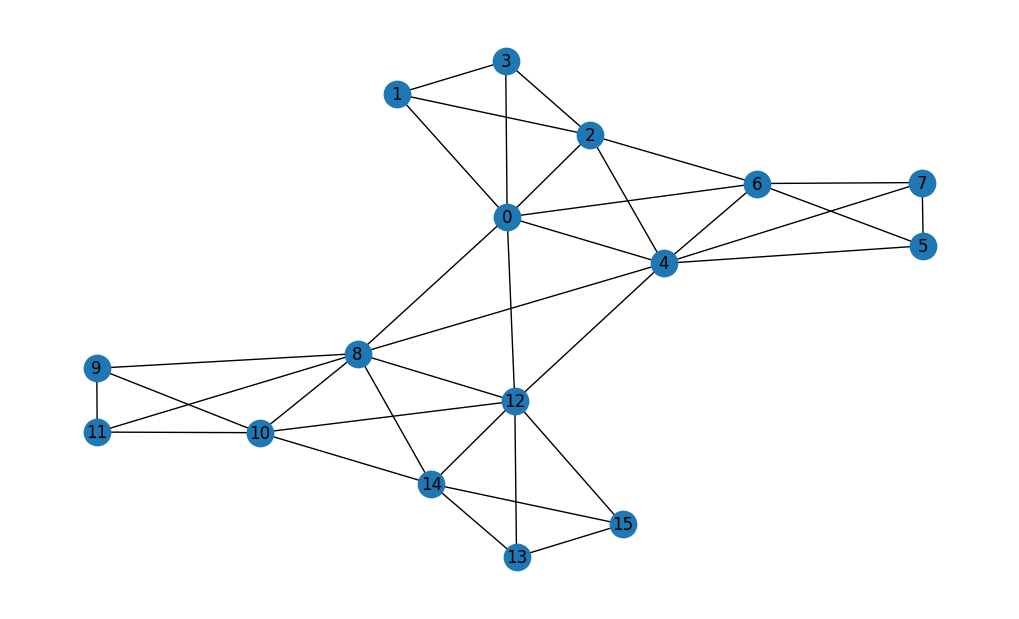

In [3]:
import networkx as nx

plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True
# Remove all the self loops
for node in adj_list:
    adj_list[node].discard(node)
G = nx.from_dict_of_lists(adj_list)
nx.draw(G, with_labels=True, node_size=100, alpha=1, linewidths=10)
plt.show()